# Funnel analysis

## Goal

The goal for this project is to perform funnel analysis for an e-commerce website. 
- understand where/when users abandon the website and get insights on user behavior 
- ways to improve the user experience
- discover bugs

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms

## Load data

In [3]:
!ls

Untitled.ipynb                 payment_page_table.csv
home_page_table.csv            search_page_table.csv
payment_confirmation_table.csv user_table.csv


In [12]:
user = pd.read_csv('user_table.csv')
user.head(2)

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male


In [13]:
homePage = pd.read_csv('home_page_table.csv')
homePage.head(2)

,user_id,page
0,313593,home_page
1,468315,home_page


In [14]:
searchPage = pd.read_csv('search_page_table.csv')
searchPage.head(2)

,user_id,page
0,15866,search_page
1,347058,search_page


In [16]:
paymentPage = pd.read_csv('payment_page_table.csv')
paymentPage.head(2)

,user_id,page
0,253019,payment_page
1,310478,payment_page


In [15]:
paid = pd.read_csv('payment_confirmation_table.csv')
paid.head(2)

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page


## Data Merging

In [32]:
data = pd.merge(left=user, right=homePage, how='left', on='user_id')

In [239]:
data2 = pd.merge(left=data, right=searchPage, how='left', on='user_id', suffixes=('_homePage', '_searchPage'))

In [36]:
data3 = pd.merge(left=data2, right=paymentPage, how='left', on='user_id')

In [37]:
data4 = pd.merge(left=data3, right=paid, how='left', on='user_id', suffixes=('_paymentPage', '_paid'))

In [38]:
data4.head(2)

,user_id,date,device,sex,page_homePage,page_searchPage,page_paymentPage,page_paid
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN


## Data Cleaning

In [242]:
dataAll = data4
dataAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           90400 non-null  int64 
 1   date              90400 non-null  object
 2   device            90400 non-null  object
 3   sex               90400 non-null  object
 4   page_homePage     90400 non-null  object
 5   page_searchPage   45200 non-null  object
 6   page_paymentPage  6030 non-null   object
 7   page_paid         452 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.2+ MB


In [246]:
dataAll['user_id'] = dataAll['user_id'].astype('str')

In [250]:
dataAll['date'] = pd.to_datetime(dataAll['date'])
dataAll['date'] = dataAll['date'].dt.date

In [409]:
dataAll.describe()

,user_id,date,device,sex,page_homePage,page_searchPage,page_paymentPage,page_paid
count,90400,90400,90400,90400,90400,45200,6030,452
unique,90400,120,2,2,1,1,1,1
top,851287,2015-02-08,Desktop,Male,home_page,search_page,payment_page,payment_confirmation_page
freq,1,877,60200,45325,90400,45200,6030,452


In [260]:
#dataAll[dataAll.duplicated()]
#df.drop_duplicates(inplace=True)
#dataAll.isnull().sum()
#df.dropna()

In [264]:
dataAll.head()

,user_id,date,device,sex,page_homePage,page_searchPage,page_paymentPage,page_paid
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [376]:
dummy = pd.get_dummies(dataAll.iloc[:,4:],prefix='',prefix_sep='')
dummy.columns = dataAll.columns[4:]
dataNew = pd.concat([dataAll.iloc[:,0:4],dummy],axis=1)

In [377]:
dataNew.head()

,user_id,date,device,sex,page_homePage,page_searchPage,page_paymentPage,page_paid
0,450007,2015-02-28,Desktop,Female,1,0,0,0
1,756838,2015-01-13,Desktop,Male,1,0,0,0
2,568983,2015-04-09,Desktop,Male,1,1,0,0
3,190794,2015-02-18,Desktop,Female,1,1,0,0
4,537909,2015-01-15,Desktop,Male,1,0,0,0


## Analysis

### Conversion rate 

First, let's look at the conversion rate for each page - home page, serach page, payment page, and confirmaiton page

In [417]:
convRate = pd.DataFrame(dataNew.iloc[:,4:].sum()/dataNew.shape[0],columns=['conversion'])
convRate.reset_index(inplace=True)

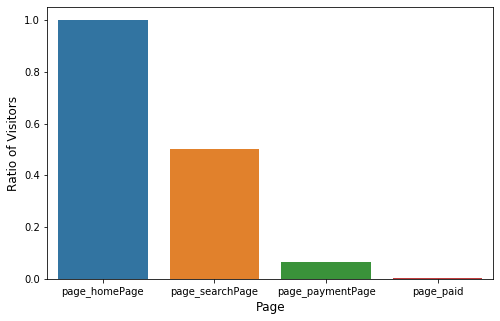

In [379]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='index', y='conversion', data=convRate, ax=ax)
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12)
plt.show()

### Conversion rate for different devices

Does different device have different conversion rate on each page? 

In [418]:
dataDevice = dataNew.groupby('device').sum()

In [381]:
dataDevice['page_paid']/dataDevice['page_homePage']

device
Desktop    0.002492
Mobile     0.010000
dtype: float64

In [382]:
dataDevice.iloc[0,1]/dataDevice.iloc[:,0].sum()


0.3329646017699115

Compared with desktop, mobile has a much higher conversion rate for final purchase(denoted by landing on confirmation page), but only 33% users use Mobile.
- why there is a difference, which funnel has problems
  - increase desktop conversion rate
- how to increase number of mobile users
  - marketing channel strategy: put ads campaigns on social media platform like Instagram, which is designed for mobile users

### Funnel conversion rate for different devices

In [416]:
convDev = pd.DataFrame()
convDev['searchPage'] =  dataDevice['page_searchPage']/ dataDevice['page_homePage']
convDev['paymentPage'] = dataDevice['page_paymentPage']/dataDevice['page_searchPage']
convDev['paid'] = dataDevice['page_paid']/dataDevice['page_paymentPage']

In [384]:
deviceplot = convDev.T
deviceplot.columns = ['Desktop','Mobile']
deviceplot.reset_index(inplace=True)
deviceplot

,index,Desktop,Mobile
0,searchPage,0.500000,0.5
1,paymentPage,0.100000,0.2
2,paid,0.049834,0.1


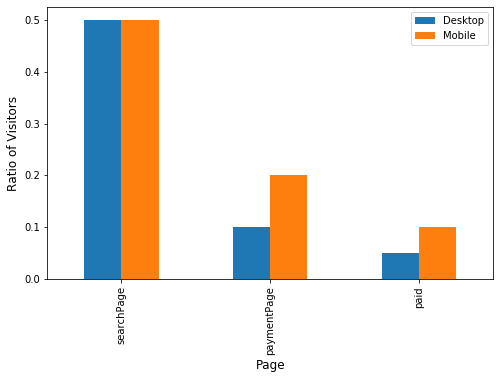

In [385]:
fig, ax = plt.subplots(figsize=(8, 5))
deviceplot.plot(x='index', y=['Desktop','Mobile'], kind="bar",ax=ax)
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12);

Desktop users have higher dropout rate at payment page and confirmation page.
- what's the reason

Let's have time series analysis to see when does the problem happen

### Time series analysis

In [411]:
date_groupby = dataNew.groupby(['device','date'],as_index=False).sum()

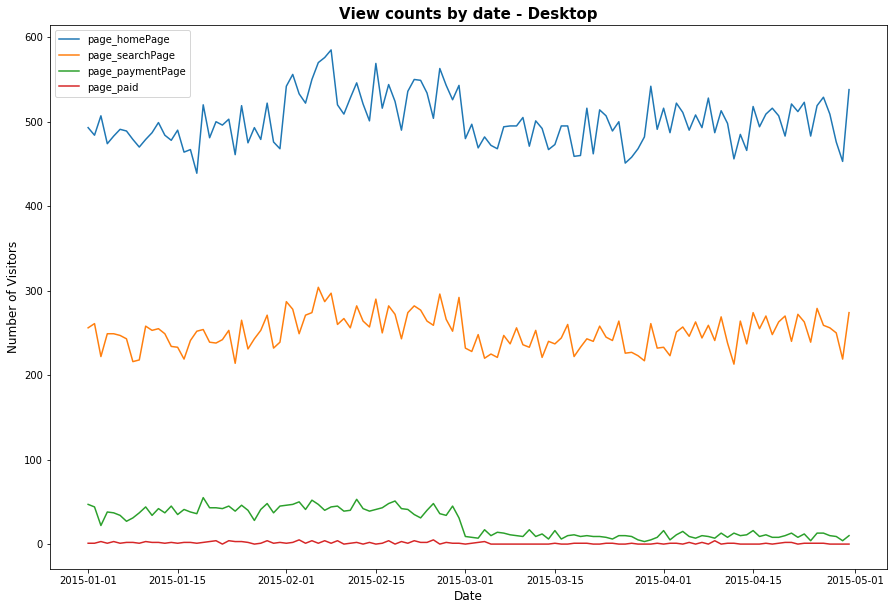

In [414]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in date_groupby.columns[2:]:
    plt.plot('date', i, data = date_groupby.query('device == "Desktop"'))
    plt.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Visitors', fontsize=12)
    plt.title('View counts by date - Desktop',fontsize=15,fontweight="bold");
    

There has been a higher leakage from payment to confirmation page since 2015-03-01.

Possible reasons
    - website layout update
    - tracking error
    - engineering testing

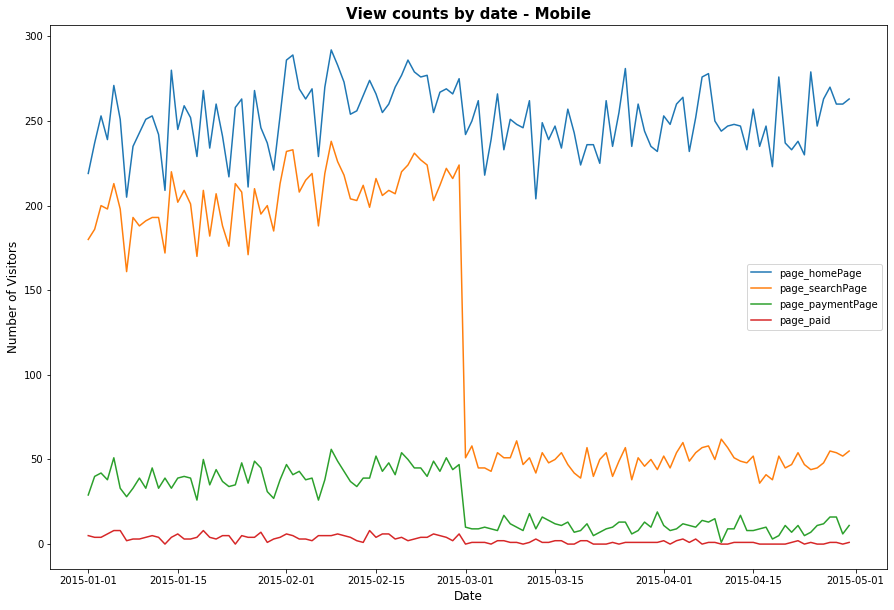

In [415]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in date_groupby.columns[2:]:
    plt.plot('date', i, data = date_groupby.query('device == "Mobile"'))
    plt.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Visitors', fontsize=12)
    plt.title('View counts by date - Mobile',fontsize=15,fontweight="bold");

Surprisingly, there was a big problem on conversion at Mobile from search page to payment page.

Possible reasons
- website layout update
- tracking error
- engineering testing

Let's look at influence on the conversion ratio

In [403]:
conTime = pd.DataFrame()
conTime['device'] = date_groupby['device']
conTime['date'] = date_groupby['date']
conTime['searchPage'] = date_groupby['page_searchPage']/date_groupby['page_homePage']
conTime['paymentPage'] = date_groupby['page_paymentPage']/date_groupby['page_searchPage']
conTime['paid'] = date_groupby['page_paid']/date_groupby['page_paymentPage']
conTime

,device,date,searchPage,paymentPage,paid
0,Desktop,2015-01-01,0.519270,0.183594,0.021277
1,Desktop,2015-01-02,0.539256,0.168582,0.022727
2,Desktop,2015-01-03,0.437870,0.099099,0.136364
3,Desktop,2015-01-04,0.525316,0.152610,0.026316
4,Desktop,2015-01-05,0.515528,0.148594,0.081081
...,...,...,...,...,...
235,Mobile,2015-04-26,0.182510,0.250000,0.000000
236,Mobile,2015-04-27,0.203704,0.290909,0.062500
237,Mobile,2015-04-28,0.207692,0.296296,0.062500
238,Mobile,2015-04-29,0.200000,0.115385,0.000000


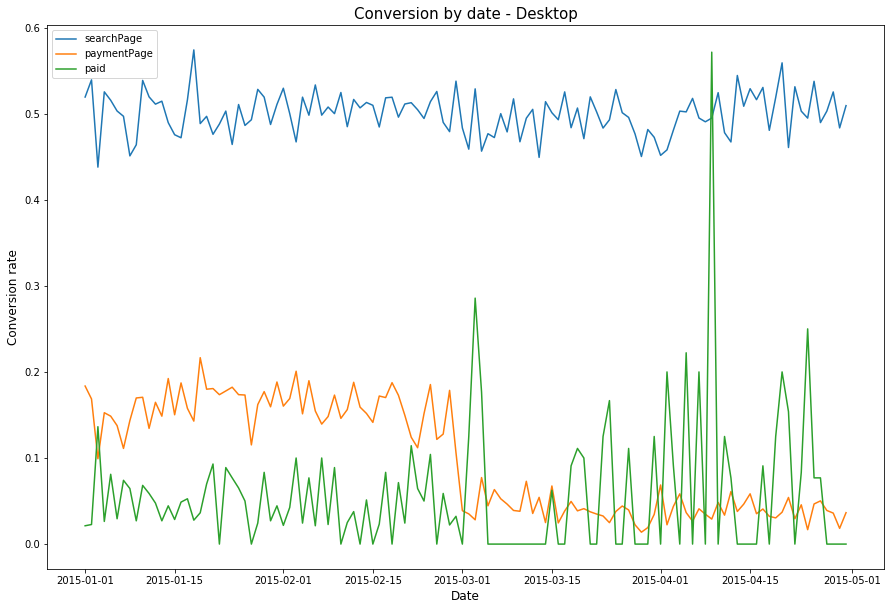

In [413]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in conTime.columns[2:]:
    plt.plot('date', i, data = conTime.query('device == "Desktop"'))
    plt.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Conversion rate', fontsize=12)
    plt.title('Conversion by date - Desktop',fontsize=15);

For Desktop users, the conversion rate from payment page to confirmation page saw an increase since 2015-03-01 while that for search page to payment page decreased; this might be related to low conversion rate of payment page

Suggestion
- check with engineering team for the reason of payment page leakage
- improve payment page funnel

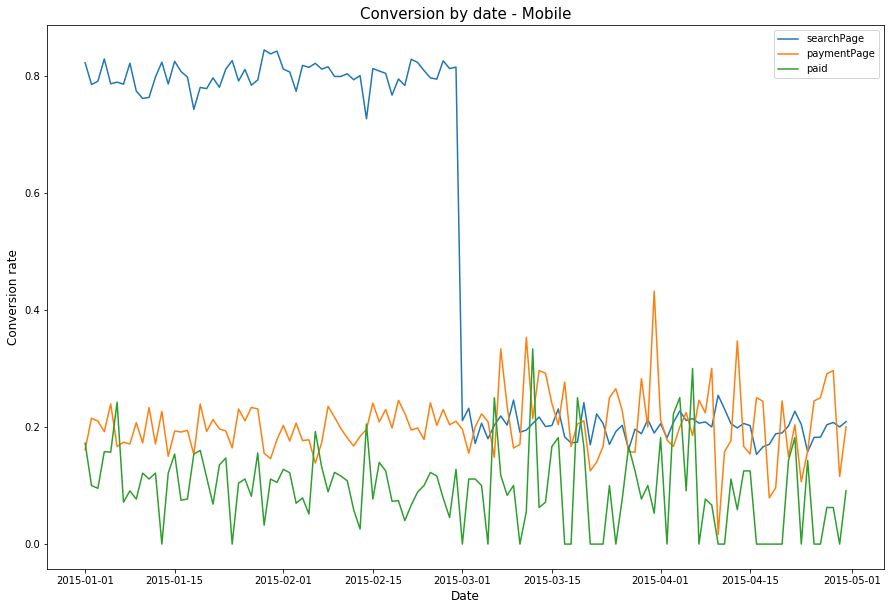

In [405]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in conTime.columns[2:]:
    plt.plot('date', i, data = conTime.query('device == "Mobile"'))
    plt.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Conversion rate', fontsize=12)
    plt.title('Conversion by date - Mobile',fontsize=15);

For Mobile, similarly, need fix the search page funnel

## Other factor - gender

In [345]:
Gender = dataNew.groupby(['device','sex']).sum()
convGen = pd.DataFrame()
convGen['searchPage'] =  Gender['page_searchPage']/ Gender['page_homePage']
convGen['paymentPage'] = Gender['page_paymentPage']/Gender['page_searchPage']
convGen['paid'] = Gender['page_paid']/Gender['page_paymentPage']
convGen

searchPage  paymentPage      paid
device  sex                                      
Desktop Female    0.503084     0.101385  0.048366
        Male      0.496937     0.098608  0.051351
Mobile  Female    0.503051     0.206987  0.106369
        Male      0.496958     0.192947  0.093103

Overall, female have higher higher conversion rate; 
pay attention to the lower confirmation rate for female desktop users
- improve website layout more attractive to female users

## Summary

Mobile has higher conversion rate compared with desktop (1% vs 0.2%), usually e-commerce conversion rate is around 1%-2%. Only 33% users are using mobile, the marketing team need invest more in mobile marketing to drive traffic.

For the funnel conversion, there must have something happen on 2015-03-01, which result in higher leakage for search page on Mobile and for payment page on Desktop. Need to coordinate with engineer team to find the reason, is it a bug, or website layout change, or competitors steal the traffic.